In [0]:
# Importing the libraries
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import os




In [21]:
#Reading the files in google colab
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [0]:
#Reading the files
import pandas as pd
import io
train= pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test= pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
train=train.drop(['Id'],1)
test=test.drop(['Id'],1)

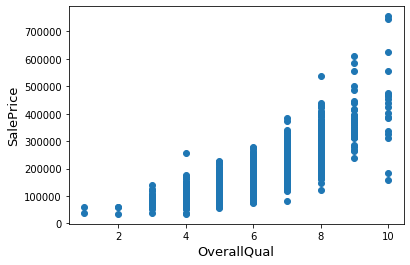

In [23]:
# Finding the outliers
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()
plt.show()
train = train.drop(train[(train['OverallQual']>9) & (train['SalePrice']<300000)].index)

In [0]:
# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)



 mu = 180932.92 and sigma = 79467.79



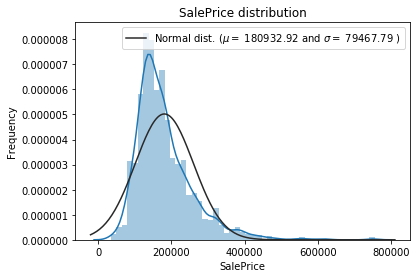

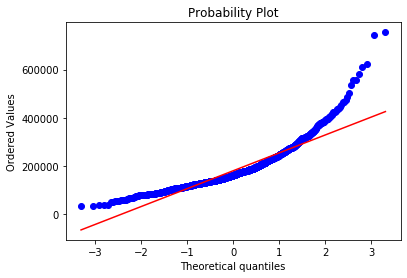

In [25]:
#Finding the distribution of the target variable
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [0]:
# Transforming the output variable
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test


In [27]:
#Concatenating the training and testing data
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2917, 79)


In [0]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 


features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

#Filling the categorical variables with the most frequently occuring values
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")


In [0]:
#Imputing the values

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [0]:
# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [31]:
#Some variables are skew
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

#Doing feature engineering 
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
#features['remodeled_y_n']=features['YearRemodAdd']-features['YearBuilt']
#features.drop(['remodeled_y_n'], axis=1, inplace=True)

features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [0]:
# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
features['cond*qual'] = (features['OverallCond'] * features['OverallQual']) / 100.0

features['home_age_when_sold'] = features['YrSold'] - features['YearBuilt']

features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [33]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)


(2917, 88)
(2917, 335)


In [34]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1458, 335) y (1458,) X_sub (1459, 335)


In [0]:
# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                       random_state=42, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [0]:
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)


START Fit
2020-01-27 08:32:43.065058 StackingCVRegressor
[08:34:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))
            
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

print('Predict submission', datetime.now(),)

submission = np.floor(np.expm1(blend_models_predict(X_sub)))

RMSLE score on train data:
0.062097107751918415
Predict submission 2020-01-15 18:20:02.119551
